# Metacritic All Time Games Statistics (1995 - 2018)

For this project, we used a dataset on Metacritic Games Reviews and Ratings from this kaggle page: https://www.kaggle.com/skateddu/metacritic-all-time-games-stats. Our goal is to ....


First, we import the necessary libraries:

In [64]:
# Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import numpy as np
import requests
import json
import pymongo
from scipy import stats 
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm

import itertools # for combinations

Next we import the dataset and preview the dataframe in pandas.

In [65]:
# Import dataset csv and preview
df = pd.read_csv('metacritic_games.csv')
df.head()

,name,platform,developer,publisher,genre,players,rating,attribute,release_date,link,critic_positive,critic_neutral,critic_negative,metascore,user_positive,user_neutral,user_negative,user_score
0,Command & Conquer,PC,Westwood Studios,Virgin Interactive,Sci-Fi,01-Apr,T,NaN,"Aug 31, 1995",/game/pc/command-conquer,5,0,0,94,47,0,1,8.9
1,Full Throttle,PC,LucasArts,LucasArts,Adventure,NaN,NaN,NaN,"Apr 30, 1995",/game/pc/full-throttle,6,2,0,86,18,1,0,8.7
2,Battle Arena Toshinden,PS,Tamsoft,SCEA,Action,01-Feb,T,NaN,"Sep 9, 1995",/game/playstation/battle-arena-toshinden,1,3,0,69,1,0,1,5.8
3,Sid Meier's Civilization II,PC,MPS Labs,MicroProse,Strategy,1 Player,K-A,NaN,"Feb 29, 1996",/game/pc/sid-meiers-civilization-ii,7,0,0,94,46,0,1,8.9
4,Quake,PC,id Software,id Software,Action,Jan-16,M,NaN,"Jun 22, 1996",/game/pc/quake,9,0,0,94,84,4,1,8.8


## Data Cleaning

### Removing incomplete rows and redundant columns

We begin data cleaning by dropping rows with missing values in developer and publisher.

In [66]:
# Drop rows with missing values in developer and publisher
df.dropna(subset=['developer', 'publisher'], inplace = True)
df.reset_index(inplace = True)
df = df.drop(['index'], axis = 1)

The following columns are dropped as they are not relevant to our research question:

In [67]:
# Drop redundant columns
df = df.drop(['players', 'attribute', 'link', 'critic_positive',
              'critic_neutral', 'critic_negative','user_positive',
              'user_neutral', 'user_negative'], axis = 1)

### Obtaining Release Year

Next, we sliced the 'release_date' to obtain the year of release and replaced the column with the appropriate 'release_year' data.

In [68]:
# Change Release Date to Release Year
year_released = []
for i in range(0,len(df['release_date'])):    
    year_released.append(df.release_date[i].split()[2])
    
df['release_date'] = year_released
df.rename(columns={"release_date": "release_year"}, inplace = True)

# Change datatype from str to integer
df[['release_year']] = df[['release_year']].astype(int)

### Rating

Rating columns are adjusted by replacing the letters with the actual rating description, as follows:
* **E** = Everyone
* **EC** = Early Childhood 3+
* **E10+** = Everyone 10+
* **T** = Teen 13+
* **M** = Mature 17+
* **AO** = Adults Only 18+
* **RP** or **K-A** = Rating Pending
* **Null values** are replaced as Rating Pending

In [69]:
# Add Description to Rating column and remove null values
for rating in df['rating']:
    if rating == 'E':
        df.rating.replace(to_replace = rating, value = 'Everyone', inplace=True)
    elif rating == 'EC':
        df.rating.replace(to_replace = rating, value = 'Early Childhood 3+', inplace=True)
    elif rating == 'E10+':
        df.rating.replace(to_replace = rating, value = 'Everyone 10+', inplace=True)
    elif rating == 'T':
        df.rating.replace(to_replace = rating, value = 'Teen 13+', inplace=True)
    elif rating == 'M':
        df.rating.replace(to_replace = rating, value = 'Mature 17+', inplace=True)
    elif rating == 'AO':
        df.rating.replace(to_replace = rating, value = 'Adults Only 18+', inplace=True)
    elif rating == 'RP' or rating == 'K-A' or type(rating) == float:
        df.rating.replace(to_replace = rating, value = 'Rating Pending', inplace=True)

### Adjusting User Score

The user_score column contains 0 null values, however 'tbd' is present, representing the user score is to be determined. As there are 2000 + values of 'tbd', we will replace the values with random-assigned values with weighted probabilities from other user review scores

In [70]:
# Assign 'tbd' values with random-assigned values with weighted probablities
choice = sorted(df[df.user_score != 'tbd']['user_score'].unique())
prob = df[df.user_score != 'tbd']['user_score'].value_counts(normalize=True).sort_index()
df['user_score'] = df.user_score.map(lambda x: np.random.choice(choice, 1, p= prob)[0] if x == 'tbd' else x)

For comparison purposes, we will adjust the user_score to be in the same format as the metascore by multiplying all values by 10 as user_score is rated on a scale of 10 while metascore is rated on a scale of 100. Appropriate datatype conversion will be performed to the values.

In [71]:
# Change datatype from str to float
df[['user_score']] = df[['user_score']].astype(float)

# Change user_score from a scale of 10 to a scale of 100 by multiplying all values by 10
df['user_score'] = df['user_score'].apply(lambda x: x * 10 )

# Change datatype from float to int
df[['user_score']] = df[['user_score']].astype(int)

In [72]:
print(df.shape)
df.head()

(20380, 9)


,name,platform,developer,publisher,genre,rating,release_year,metascore,user_score
0,Command & Conquer,PC,Westwood Studios,Virgin Interactive,Sci-Fi,Teen 13+,1995,94,89
1,Full Throttle,PC,LucasArts,LucasArts,Adventure,Rating Pending,1995,86,87
2,Battle Arena Toshinden,PS,Tamsoft,SCEA,Action,Teen 13+,1995,69,58
3,Sid Meier's Civilization II,PC,MPS Labs,MicroProse,Strategy,Rating Pending,1996,94,89
4,Quake,PC,id Software,id Software,Action,Mature 17+,1996,94,88


Great! We now have a clean dataframe in the right format with no missing values. The dataframe has a shape of **9 columns x 20380 rows**. We can now begin our data analysis and hypothesis testing.

## Data Analysis 

In [73]:
# platform_boolean = []
# for platform in df['platform']:
#     if platform == 'PC':
#         platform_boolean.append('PC')
#     else:
#         platform_boolean.append('Console')
# df['platform_bool'] = platform_boolean

# Segment our data into few ranges of years for analysis
year_boolean = []
for year in df['release_year']:
    if year == 2013 or year == 2014:
        year_boolean.append('13-14')
    elif year == 2015 or year == 2016:
        year_boolean.append('15-16')
    elif year == 2017 or year == 2018:
        year_boolean.append('17-18')
    elif year < 2013:
        year_boolean.append('Others')
df['year_bool'] = year_boolean

# To check average score between metascore and user score
avg_score = []
for i in range(0,len(df)):
    avg_score.append((df.metascore[i] + df.user_score[i])/2)
df['avg_score'] = avg_score

# To display the description of the scoring system
score_indication = []
for score in df['avg_score']:
    if score >= 90:
        score_indication.append('Universal Acclaim')
    elif score >= 75 and score <= 89:
        score_indication.append('Favorable')
    elif score >= 50 and score <= 74:
        score_indication.append('Average')
    elif score >= 20 and score <= 49:
        score_indication.append('Unfavorable')
    else:
        score_indication.append('Overwhelming Dislike')
df['score_indication'] = score_indication 

In [74]:
# Re-index the column order
df = df.reindex(columns=['name', 'platform', 'developer','publisher',
                         'genre', 'rating', 'release_year','year_bool', 
                         'metascore', 'user_score', 'avg_score', 'score_indication'])
df.head()

,name,platform,developer,publisher,genre,rating,release_year,year_bool,metascore,user_score,avg_score,score_indication
0,Command & Conquer,PC,Westwood Studios,Virgin Interactive,Sci-Fi,Teen 13+,1995,Others,94,89,91.5,Universal Acclaim
1,Full Throttle,PC,LucasArts,LucasArts,Adventure,Rating Pending,1995,Others,86,87,86.5,Favorable
2,Battle Arena Toshinden,PS,Tamsoft,SCEA,Action,Teen 13+,1995,Others,69,58,63.5,Average
3,Sid Meier's Civilization II,PC,MPS Labs,MicroProse,Strategy,Rating Pending,1996,Others,94,89,91.5,Universal Acclaim
4,Quake,PC,id Software,id Software,Action,Mature 17+,1996,Others,94,88,91.0,Universal Acclaim


In [76]:
actiondf = df[df.genre == 'Action']
actiondf.metascore.groupby([df.year_bool,df.genre]).describe()

,,count,mean,std,min,25%,50%,75%,max
year_bool,genre,,,,,,,,
13-14,Action,780.0,68.794872,13.735685,17.0,61.0,72.0,79.0,94.0
15-16,Action,943.0,69.092259,12.094505,15.0,63.0,71.0,77.0,93.0
17-18,Action,1089.0,70.808999,11.154343,28.0,65.0,72.0,79.0,97.0
Others,Action,4288.0,66.299674,14.458211,18.0,57.0,68.0,77.0,98.0


In [77]:
actiondf_1314 = actiondf[actiondf['year_bool'] == '13-14']
actiondf_1516 = actiondf[actiondf['year_bool'] == '15-16']
actiondf_1718 = actiondf[actiondf['year_bool'] == '17-18']

In [78]:
sample_1314 = actiondf_1314.sample(100)
sample_1516 = actiondf_1516.sample(100)
sample_1718 = actiondf_1718.sample(100)

In [79]:
sample_merged = pd.concat([sample_1314, sample_1516, sample_1718])

In [80]:
sample_merged['metascore'].groupby(by = sample_merged.year_bool).describe()

,count,mean,std,min,25%,50%,75%,max
year_bool,,,,,,,,
13-14,100.0,67.22,14.770008,32.0,58.5,72.0,77.25,90.0
15-16,100.0,69.86,12.288633,21.0,63.0,72.5,79.00,92.0
17-18,100.0,72.80,8.528029,49.0,68.0,74.0,79.00,92.0


In [81]:
formula = 'metascore ~ C(year_bool)'
lm = ols(formula, sample_merged).fit()
table = sm.stats.anova_lm(lm, typ=1)
print(table)

                 df    sum_sq    mean_sq         F    PR(>F)
C(year_bool)    2.0   1558.32  779.16000  5.289722  0.005529
Residual      297.0  43747.20  147.29697       NaN       NaN


In [82]:
mc = MultiComparison(sample_merged.metascore, sample_merged.year_bool)
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 13-14  15-16     2.64  0.275 -1.4032 6.6832  False
 13-14  17-18     5.58 0.0037  1.5368 9.6232   True
 15-16  17-18     2.94 0.2022 -1.1032 6.9832  False
---------------------------------------------------


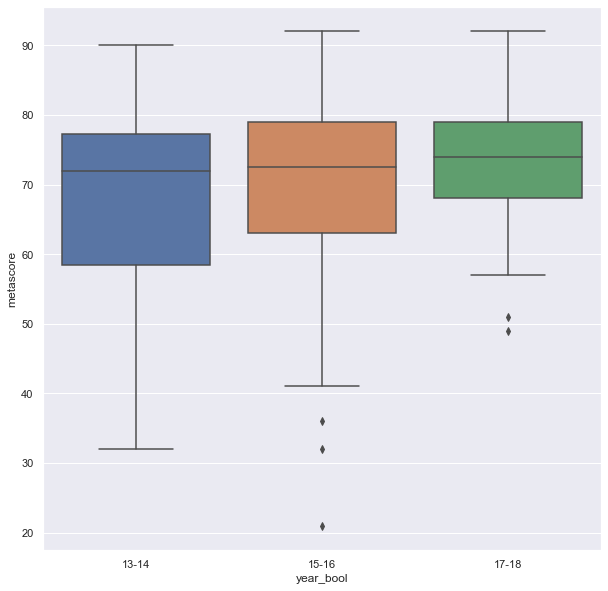

In [83]:
fig = plt.subplots(figsize = (10,10))
sns.boxplot(x='year_bool', y='metascore', data=sample_merged)

# Atlus vs Zen Studios vs Ubisoft

In [84]:
df_ubisoft = df[df.publisher == 'Ubisoft']
df_atlus = df[df.publisher == 'Atlus']
df_zen = df[df.publisher == 'Zen Studios']

df_merged = pd.concat([df_ubisoft,df_atlus,df_zen])

In [85]:
formula = 'metascore ~  C(publisher)'
lm = ols(formula, df_merged).fit()
table = sm.stats.anova_lm(lm, typ=1)
print(table)

                  df         sum_sq      mean_sq          F        PR(>F)
C(publisher)     2.0    4759.930221  2379.965110  14.155284  8.484951e-07
Residual      1123.0  188812.941005   168.132628        NaN           NaN


In [86]:
mc = MultiComparison(df_merged.metascore, df_merged.publisher)
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1    group2   meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Atlus     Ubisoft  -1.1511 0.5626 -3.8105  1.5083  False
  Atlus Zen Studios   7.6684  0.001  3.1629 12.1738   True
Ubisoft Zen Studios   8.8195  0.001  4.9123 12.7267   True
----------------------------------------------------------


In [91]:
def cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [92]:
cohen_d(df_atlus.metascore, df_zen.metascore)

0.6588606783480686

In [93]:
cohen_d(df_ubisoft.metascore, df_zen.metascore)

0.6771648965101973

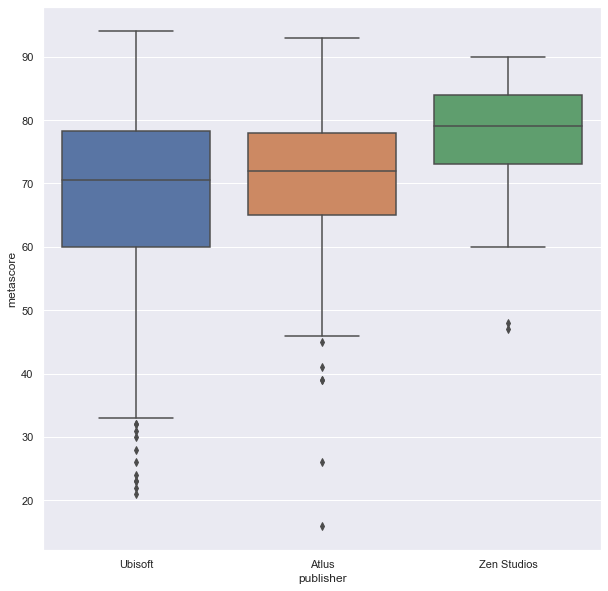

In [90]:
fig = plt.subplots(figsize = (10,10))
sns.boxplot(x='publisher', y='metascore', data=df_merged)

# Hypothesis 3

In [96]:
PC_df = df[df.platform == 'PC']

meta_sample = PC_df["metascore"]
user_sample = PC_df["user_score"]

In [97]:
def welch_t(a, b):

    numerator = a.mean() - b.mean()
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

welch_t(meta_sample,user_sample)

6.109717144616039

In [98]:
def welch_df(a, b):
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator
        
welch_df(meta_sample, user_sample)

10746.343973457178

In [99]:
def p_value(a, b, two_sided=False):

    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

p_value(meta_sample, user_sample)

5.163274252595329e-10

In [100]:
cohen_d(meta_sample, user_sample)

0.1173103231670341

In [102]:
def effect_size(a, b):
    e = a.mean()-b.mean()
    
    return e

effect_size(meta_sample, user_sample)

1.5494930875576074